# Тестовое для сбер

### Описание задачи
В качестве тестового задания предрставлен датасет online_shoppers_intention.csv, который содержит информацию о посетителях интернет-магазина и их поведении на сайте. Необходимо проанализировать данный датасет, определив какие действия могут привести к конверсии и создать классификатор на основе гипотез.

В качестве ответа необходимо предоставить Jupyter Notebook с вашим анализом и модель машинного обучения, которая сможет предсказывать, приносят ли действия пользователя Revenue или нет.

### План работы


1. Загрузка и первичный осмотр данных:
   - Импорт необходимых библиотек
   - Загрузка датасетов
   - Проверка типов данных и наличия пропусков
2. Анализ переменных:
   - Изучение распределения переменных
   - Изучение распределения и зависимости между различными признаками и целевой переменной.
   - Изучение распределения целевой переменной "Revenue" (например, с помощью гистограммы или диаграммы количества).
   - Изучение мультиколлинерности между признаками
   - Определение наиболее важных признаков для прогнозирования оттока клиентов.
   - Проверка важности новых признаков и их влияние на целевую переменную с помощью статистических тестов или визуализации.
3. Подготовка данных для моделирования:
   - Кодировка категориальных переменных, используя методы, такие как One-Hot Encoding или Label Encoding (если требуется).
   - Разделение данных на тренировочный и тестовый наборы.
   - Масштабирование числовых признаки, если требуется, чтобы они имели одинаковый масштаб.

4. Моделирование и оценка:
   - Выбор подходящих моделей машинного обучения для задачи прогнозирования revenue
   - Обучение моделей на тренировочных данных.
   - Оценка производительности модели и подбор гиперпараметров на кросс-валидации с помощью метрик, таких как F1-мера, ROC-AUC

7. Выводы и интерпретация результатов

### Цель работы:
- Определить какие действия могут привести к конверсии, какие признаки оказывают большее влиянние на поведение клиента
- Создать классификатор на основе ваших гипотез, определив метрику, по которой мы будем оценивать модель

### 1. Загрузка и первичный осмотр данных

In [1]:
# установка необходимых библиотек
!pip install phik
!pip install catboost
!pip install seaborn
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 11.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, make_scorer
from catboost import CatBoostClassifier
from scipy.stats import randint as sp_randint

# чтобы игнорировать ошибки
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_curve,
    roc_auc_score)
from sklearn.utils import shuffle
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
import time
import seaborn as sns

from sklearn.metrics import confusion_matrix

In [4]:
# lightgbm импрортирую отдельно, потому что не во всех ос он работает
import lightgbm as lgb

In [5]:
# зададим константы
RANDOM_STATE = 220523
TEST_SIZE = 0.25

In [6]:
# устанавливаем связь с гугл диском для работы в колабе
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# загрузим датасет
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/online_shoppers_intention.csv')
except:
    df = pd.read_csv('/Users/gazizovilsur26/Downloads/online_shoppers_intention.csv')

In [8]:
# выведем 10 строк датасета contract_new
df.head(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
5,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False
6,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.4,Feb,2,4,3,3,Returning_Visitor,False,False
7,1,0.0,0,0.0,0,0.000000,0.200000,0.200000,0.0,0.0,Feb,1,2,1,5,Returning_Visitor,True,False
8,0,0.0,0,0.0,2,37.000000,0.000000,0.100000,0.0,0.8,Feb,2,2,2,3,Returning_Visitor,False,False
9,0,0.0,0,0.0,3,738.000000,0.000000,0.022222,0.0,0.4,Feb,2,4,1,2,Returning_Visitor,False,False


In [9]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [10]:
# посмотрим на тип данных и пропуски
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

**Разъяснения для каждого из столбцов в датасете:**

- `Administrative`: Число посещений административных страниц сайта пользователем.
- `Administrative_Duration`: Общая продолжительность времени, проведенного пользователем на административных страницах.
- `Informational`: Число посещений информационных страниц сайта пользователем.
- `Informational_Duration`: Общая продолжительность времени, проведенного пользователем на информационных страницах.
- `ProductRelated`: Число посещений страниц, связанных с продуктами, сайта пользователем.
- `ProductRelated_Duration`: Общая продолжительность времени, проведенного пользователем на страницах, связанных с продуктами.
- `BounceRates`: предпоалагаю, что это соотношение посетителей, которые покинули сайт после просмотра только одной страницы, к общему числу посетителей.
- `ExitRates`: предпоалагаю, что это соотношение посетителей, которые покинули сайт после просмотра данной страницы, к числу посещений данной страницы.
- `PageValues`: Средняя стоимость страницы, которую пользователь посещал перед завершением сеанса или покупкой.
- `SpecialDay`: Ближайшая праздничная дата (например, День матери или День благодарения) от момента посещения сайта пользователя.
- `Month`: Месяц, в котором пользователь посетил сайт.
- `OperatingSystems`: Идентификатор операционной системы пользователя.
- `Browser`: Идентификатор браузера пользователя.
- `Region`: Идентификатор региона пользователя.
- `TrafficType`: Идентификатор типа трафика, через который пользователь пришел на сайт.
- `VisitorType`: Тип посетителя, где "Returning Visitor" означает возвращающегося посетителя, "New Visitor" - нового посетителя, а "Other" - другой тип посетителя.
- `Weekend`: Бинарный признак, указывающий, было ли посещение сайта в выходные дни.
- `Revenue`: Бинарный признак, указывающий, совершил ли пользователь покупку (1 - да, 0 - нет). Это является целевой переменной, которую требуется предсказать

**Промежуточный вывод:**
- Пропусков нет
- Типы данных у признаков нас устраивают, менять ничего не будем
- В датасете 12330 объектов, 18 признаков

### 2. Анализ переменных

In [11]:
# напишем функцию для отображения гистограмм распределения катеогориальных признаков
def hist_for_cat(data):
    categorical_features = data.select_dtypes(include='object').columns
    num_plots = len(categorical_features)
    num_cols = 2
    num_rows = num_plots // num_cols + 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*10))
    fig.suptitle('Гистограммы для категориальных признаков датасета', fontsize=16)

    for i, feature in enumerate(categorical_features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        value_counts = data[feature].value_counts()
        ax.bar(value_counts.index, value_counts.values)

        ax.set_title(feature)
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')

    # Удаление лишних подзаголовков
    for j in range(i + 1, num_rows * num_cols):
        axes.flatten()[j].remove()

    # Отображение графиков
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

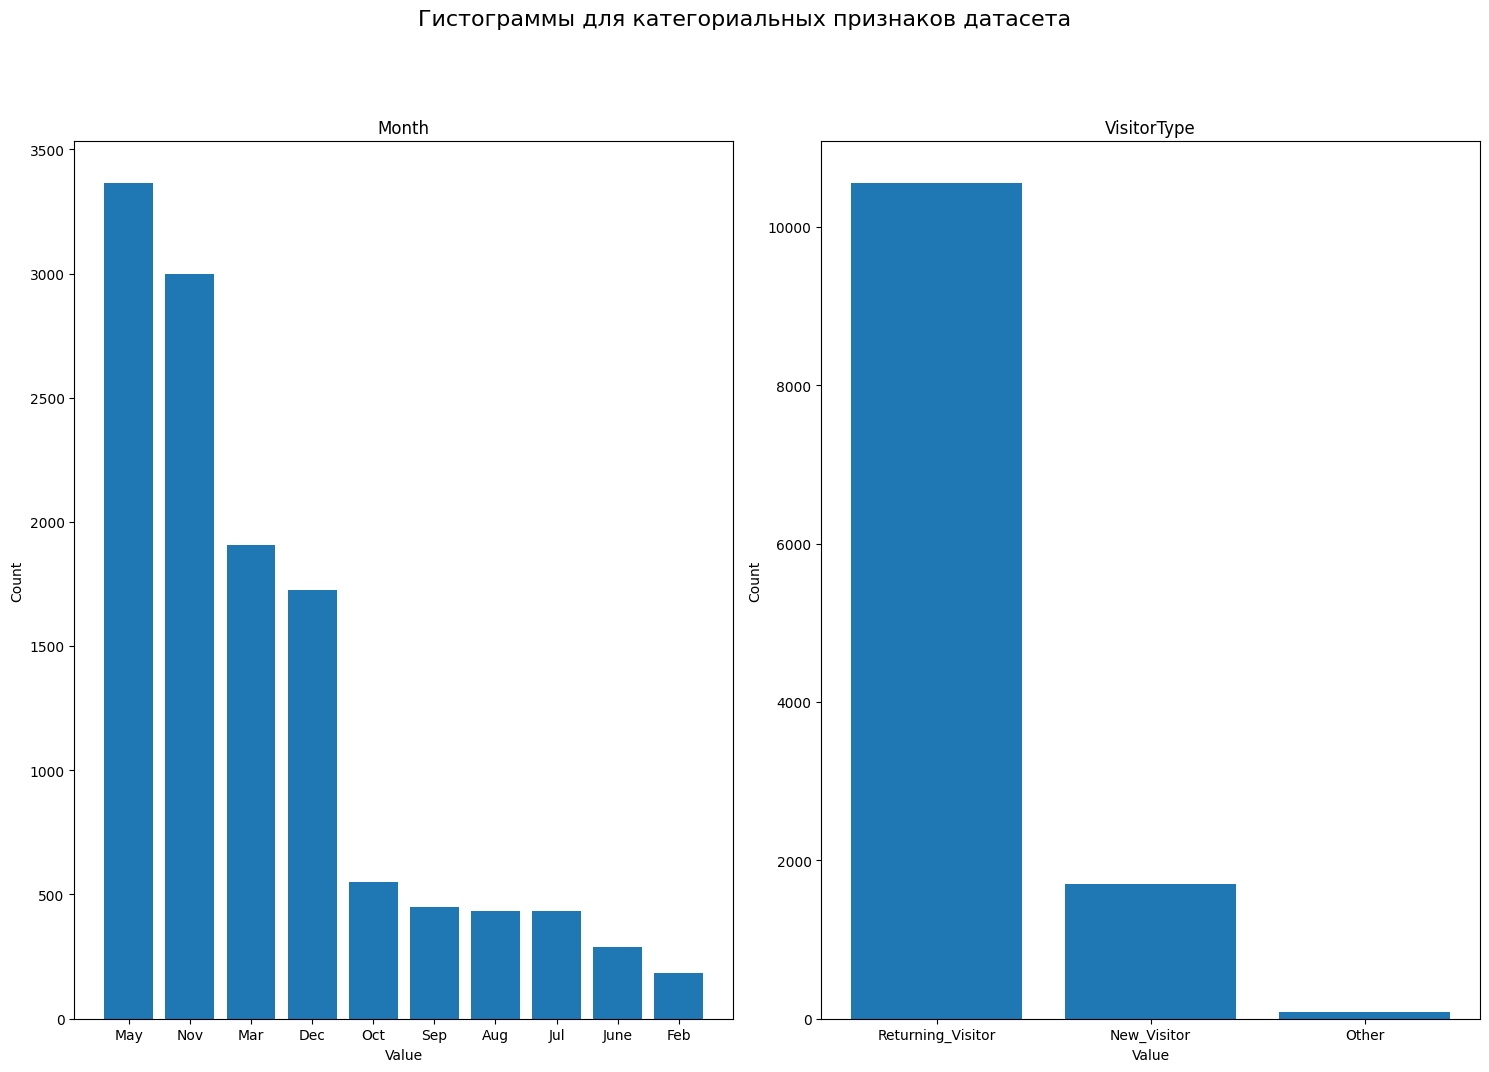

In [12]:
# применим функцию к признакам Month и VisitorType нашего датасета
hist_for_cat(df)

In [13]:
df['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

**Промежуточный вывод:**
- Данные доступны начиная с февраля, поэтому нет данных за январь и в феврале мало данных
- Наибольшее активность в интернет-магазине наблюдается в мае и ноябре
- Большинство посетителей магазина уже раньше посещали сайт

In [14]:
# сгруппируем данные по месяцам, применим mean, отсортируем по среднему revenue за месяц
revenue_by_month = df.groupby(by='Month').mean().sort_values(by='Revenue', ascending=False)
revenue_by_month

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue
Month,,,,,,,,,,,,,,,,
Nov,2.617412,90.933310,0.646431,43.634938,46.038692,1758.397922,0.019259,0.038202,7.129379,0.000000,2.116077,2.250834,3.033689,4.454303,0.263843,0.253502
Oct,3.719490,125.939345,0.488160,38.666926,33.566485,1116.977684,0.011849,0.029011,8.645580,0.000000,2.056466,2.227687,3.193078,4.276867,0.262295,0.209472
Sep,3.334821,109.325429,0.566964,35.736835,33.104911,1253.388150,0.012183,0.030320,7.556826,0.000000,2.140625,2.486607,3.294643,3.332589,0.214286,0.191964
Aug,3.136259,106.717288,0.542725,35.514365,38.258661,1272.653654,0.018211,0.037727,5.938070,0.000000,2.071594,2.378753,3.249423,3.512702,0.221709,0.175520
Jul,2.423611,78.874358,0.516204,45.520409,36.407407,1217.604028,0.024676,0.045330,4.104414,0.000000,2.094907,2.379630,3.414352,3.682870,0.240741,0.152778
Dec,2.196294,78.632929,0.512449,38.069358,27.994789,1111.470727,0.020149,0.041303,6.833243,0.000000,2.253619,2.613202,3.393746,4.068327,0.211928,0.125072
May,1.964923,69.471790,0.423900,27.163159,26.487812,981.893060,0.026867,0.048850,5.431574,0.212366,2.120095,2.368906,3.134958,4.476813,0.212545,0.108502
June,2.274306,59.129946,0.562500,20.450775,36.065972,1213.377604,0.035102,0.058242,3.391440,0.000000,2.131944,2.315972,3.190972,4.211806,0.163194,0.100694
Mar,1.887782,71.231507,0.420556,30.673764,19.808600,812.282992,0.021728,0.044600,3.959682,0.000000,2.078658,2.291557,3.033561,3.178815,0.252229,0.100682


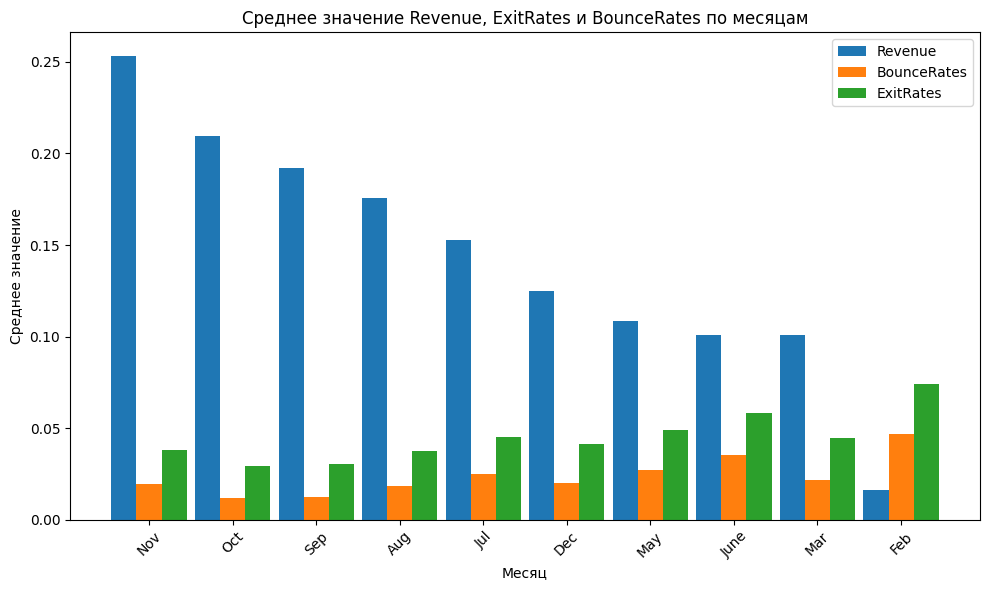

In [15]:
# Установка размера графика
plt.figure(figsize=(10, 6))

# Ширина каждого столбца
bar_width = 0.3

# Сдвиги для каждой гистограммы
bar_positions1 = np.arange(len(revenue_by_month.index))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions2 + bar_width

# Построение гистограммы для Revenue
plt.bar(bar_positions1, revenue_by_month['Revenue'], width=bar_width, label='Revenue')

# Построение гистограммы для BounceRates
plt.bar(bar_positions2, revenue_by_month['BounceRates'], width=bar_width, label='BounceRates')

# Построение гистограммы для ExitRates
plt.bar(bar_positions3, revenue_by_month['ExitRates'], width=bar_width, label='ExitRates')

# Настройка осей и заголовка
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.title('Среднее значение Revenue, ExitRates и BounceRates по месяцам')

# Подписи на оси x
plt.xticks(bar_positions2, revenue_by_month.index, rotation=45)

# Добавление легенды
plt.legend()

# Отображение графика
plt.tight_layout()
plt.show()


In [16]:
# сгруппируем данные по Revenue и выведим средние значения признаков
df.groupby(by='Revenue').mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend
Revenue,,,,,,,,,,,,,,,
False,2.117732,73.740111,0.451833,30.236237,28.714642,1069.987809,0.025317,0.047378,1.975998,0.068432,2.129726,2.339474,3.159278,4.078392,0.227308
True,3.393606,119.483244,0.786164,57.611427,48.210168,1876.209615,0.005117,0.019555,27.264518,0.023166,2.092767,2.453354,3.082285,4.021488,0.261530


**Промежуточный вывод:**
- По гистограммам видно, что наблюдается тренд к отрицательной корреляции между средним значением `Revenue` по месяцам и `BounceRates`, `ExitRates`
- Также по сводной таблице видно, что у положительного класса `Revenue` среднее значение количество посещённых страничек и длительность сессии больше как минимум в полтора раза

In [17]:
# выведим статистики по признакам
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Проанализируем распределения признаков для двух классов (Revenue: да и нет) и определим, есть ли заметные различия

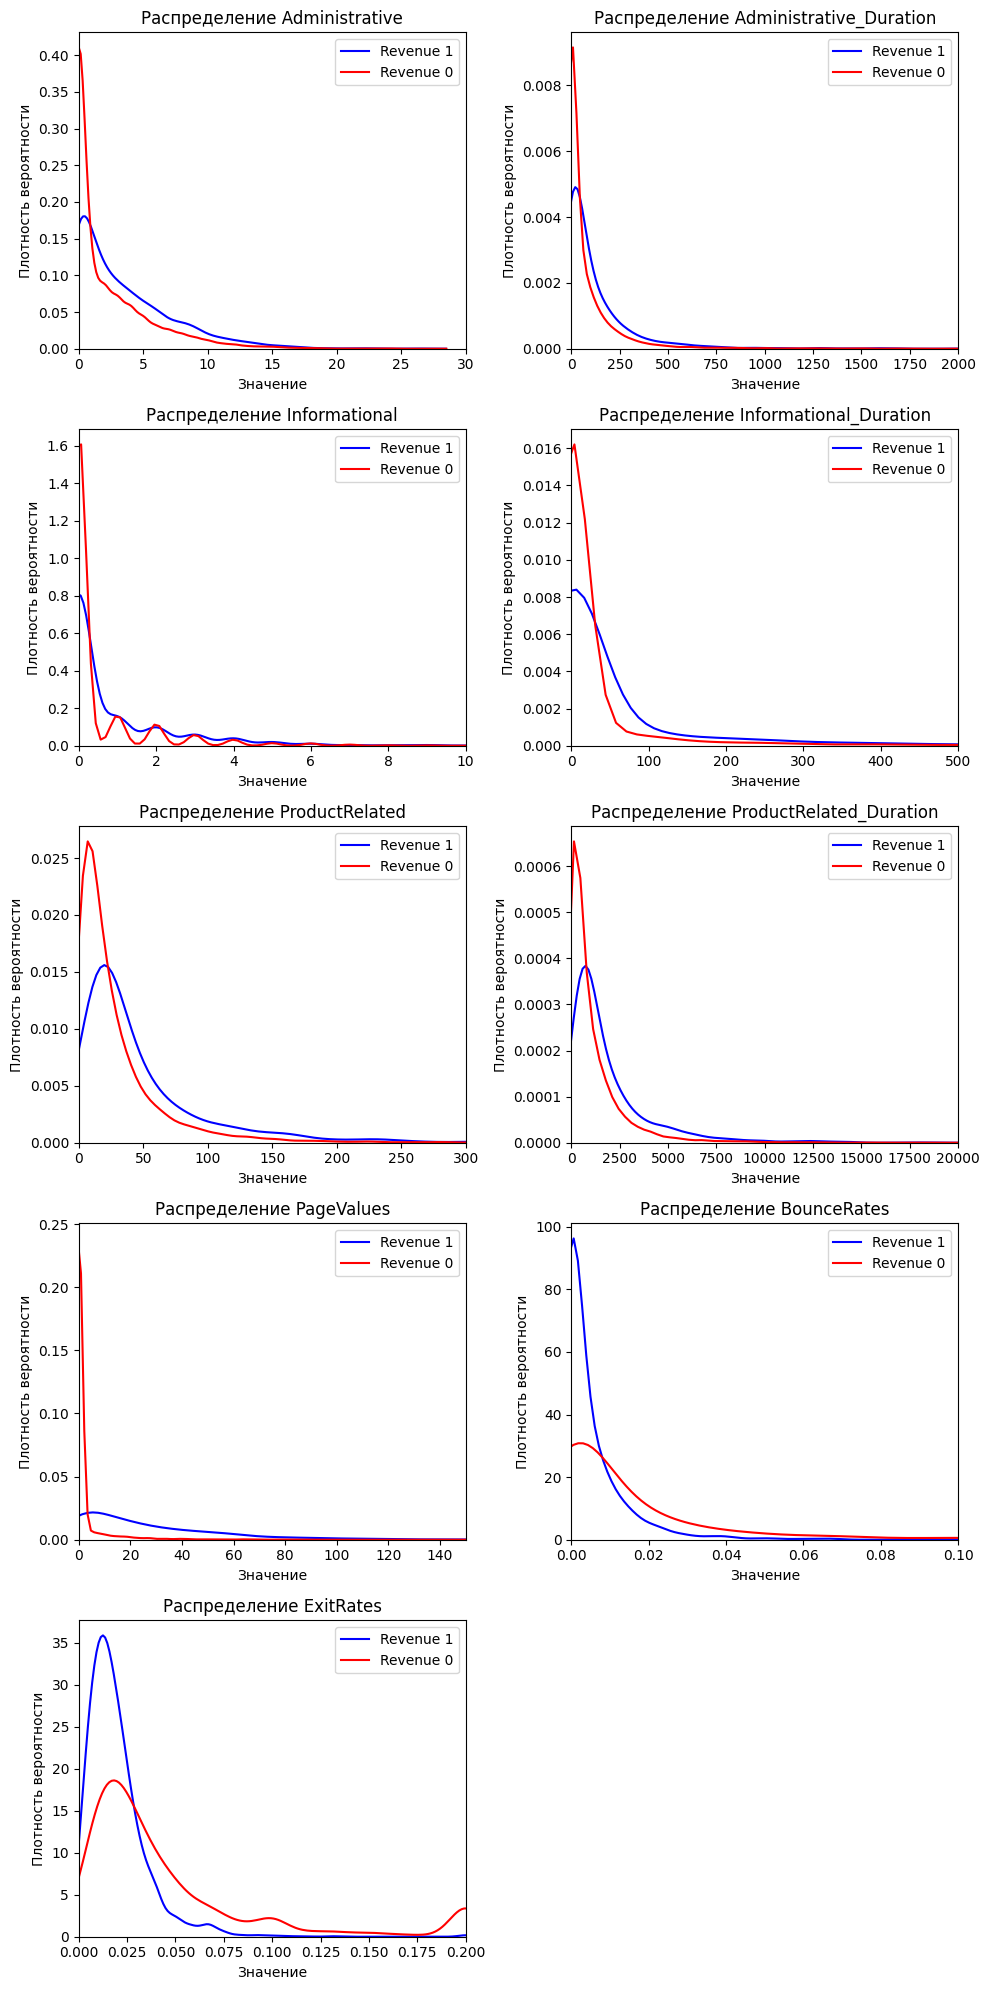

In [18]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

# Построение плотностей распределения для Administrative
sns.kdeplot(df.loc[df['Revenue']==1, 'Administrative'], ax=axes[0, 0], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'Administrative'], ax=axes[0, 0], label='Revenue 0', color='red')
axes[0, 0].set_xlim(0, 30)
axes[0, 0].set_title('Распределение Administrative')
axes[0, 0].set_xlabel('Значение')
axes[0, 0].set_ylabel('Плотность вероятности')
axes[0, 0].legend()

# Построение плотностей распределения для Administrative_Duration
sns.kdeplot(df.loc[df['Revenue']==1, 'Administrative_Duration'], ax=axes[0, 1], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'Administrative_Duration'], ax=axes[0, 1], label='Revenue 0', color='red')
axes[0, 1].set_xlim(0, 2000)
axes[0, 1].set_title('Распределение Administrative_Duration')
axes[0, 1].set_xlabel('Значение')
axes[0, 1].set_ylabel('Плотность вероятности')
axes[0, 1].legend()

# Построение плотностей распределения для Informational
sns.kdeplot(df.loc[df['Revenue']==1, 'Informational'], ax=axes[1, 0], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'Informational'], ax=axes[1, 0], label='Revenue 0', color='red')
axes[1, 0].set_xlim(0, 10)
axes[1, 0].set_title('Распределение Informational')
axes[1, 0].set_xlabel('Значение')
axes[1, 0].set_ylabel('Плотность вероятности')
axes[1, 0].legend()

# Построение плотностей распределения для Informational_Duration
sns.kdeplot(df.loc[df['Revenue']==1, 'Informational_Duration'], ax=axes[1, 1], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'Informational_Duration'], ax=axes[1, 1], label='Revenue 0', color='red')
axes[1, 1].set_xlim(0, 500)
axes[1, 1].set_title('Распределение Informational_Duration')
axes[1, 1].set_xlabel('Значение')
axes[1, 1].set_ylabel('Плотность вероятности')
axes[1, 1].legend()

# Построение плотностей распределения для ProductRelated
sns.kdeplot(df.loc[df['Revenue']==1, 'ProductRelated'], ax=axes[2, 0], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'ProductRelated'], ax=axes[2, 0], label='Revenue 0', color='red')
axes[2, 0].set_xlim(0, 300)
axes[2, 0].set_title('Распределение ProductRelated')
axes[2, 0].set_xlabel('Значение')
axes[2, 0].set_ylabel('Плотность вероятности')
axes[2, 0].legend()

# Построение плотностей распределения для ProductRelated_Duration
sns.kdeplot(df.loc[df['Revenue']==1, 'ProductRelated_Duration'], ax=axes[2, 1], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'ProductRelated_Duration'], ax=axes[2, 1], label='Revenue 0', color='red')
axes[2, 1].set_xlim(0, 20000)
axes[2, 1].set_title('Распределение ProductRelated_Duration')
axes[2, 1].set_xlabel('Значение')
axes[2, 1].set_ylabel('Плотность вероятности')
axes[2, 1].legend()

# Построение плотностей распределения для PageValues
sns.kdeplot(df.loc[df['Revenue']==1, 'PageValues'], ax=axes[3, 0], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'PageValues'], ax=axes[3, 0], label='Revenue 0', color='red')
axes[3, 0].set_xlim(0, 150)
axes[3, 0].set_title('Распределение PageValues')
axes[3, 0].set_xlabel('Значение')
axes[3, 0].set_ylabel('Плотность вероятности')
axes[3, 0].legend()

# Построение плотностей распределения для BounceRates
sns.kdeplot(df.loc[df['Revenue']==1, 'BounceRates'], ax=axes[3, 1], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'BounceRates'], ax=axes[3, 1], label='Revenue 0', color='red')
axes[3, 1].set_xlim(0, 0.1)
axes[3, 1].set_title('Распределение BounceRates')
axes[3, 1].set_xlabel('Значение')
axes[3, 1].set_ylabel('Плотность вероятности')
axes[3, 1].legend()

# Построение плотностей распределения для ExitRates
sns.kdeplot(df.loc[df['Revenue']==1, 'ExitRates'], ax=axes[4, 0], label='Revenue 1', color='blue')
sns.kdeplot(df.loc[df['Revenue']==0, 'ExitRates'], ax=axes[4, 0], label='Revenue 0', color='red')
axes[4, 0].set_xlim(0, 0.2)
axes[4, 0].set_title('Распределение ExitRates')
axes[4, 0].set_xlabel('Значение')
axes[4, 0].set_ylabel('Плотность вероятности')
axes[4, 0].legend()

# Удаление последнего пустого графика
fig.delaxes(axes[4, 1])

# Отображение графиков
plt.tight_layout()
plt.show()


**Промежучтоный вывод:**
- Распределение всех числовых признаков Пуассоновское, но различия есть
- Признаки, связанные с количеством посещений страниц, продолжительностью сеанса и PageValues, проявляют большую вариабельность (дисперсию) для объектов класса 1. В то же время, в случае класса 0, большая часть площади под графиком плотности распределения сосредоточена в области низких значений. В случае класса 1 эта площадь распространяется и на значения, отличные от нуля.
- `BounceRates` и `ExitRates` наоборот имею большую дисперсию для класса 0. То есть страницы с высокими показателями отказа и выхода провоцируют уход клиента с сайта без покупки


In [19]:
# посчитаем корреляционные коэффициенты phik
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']


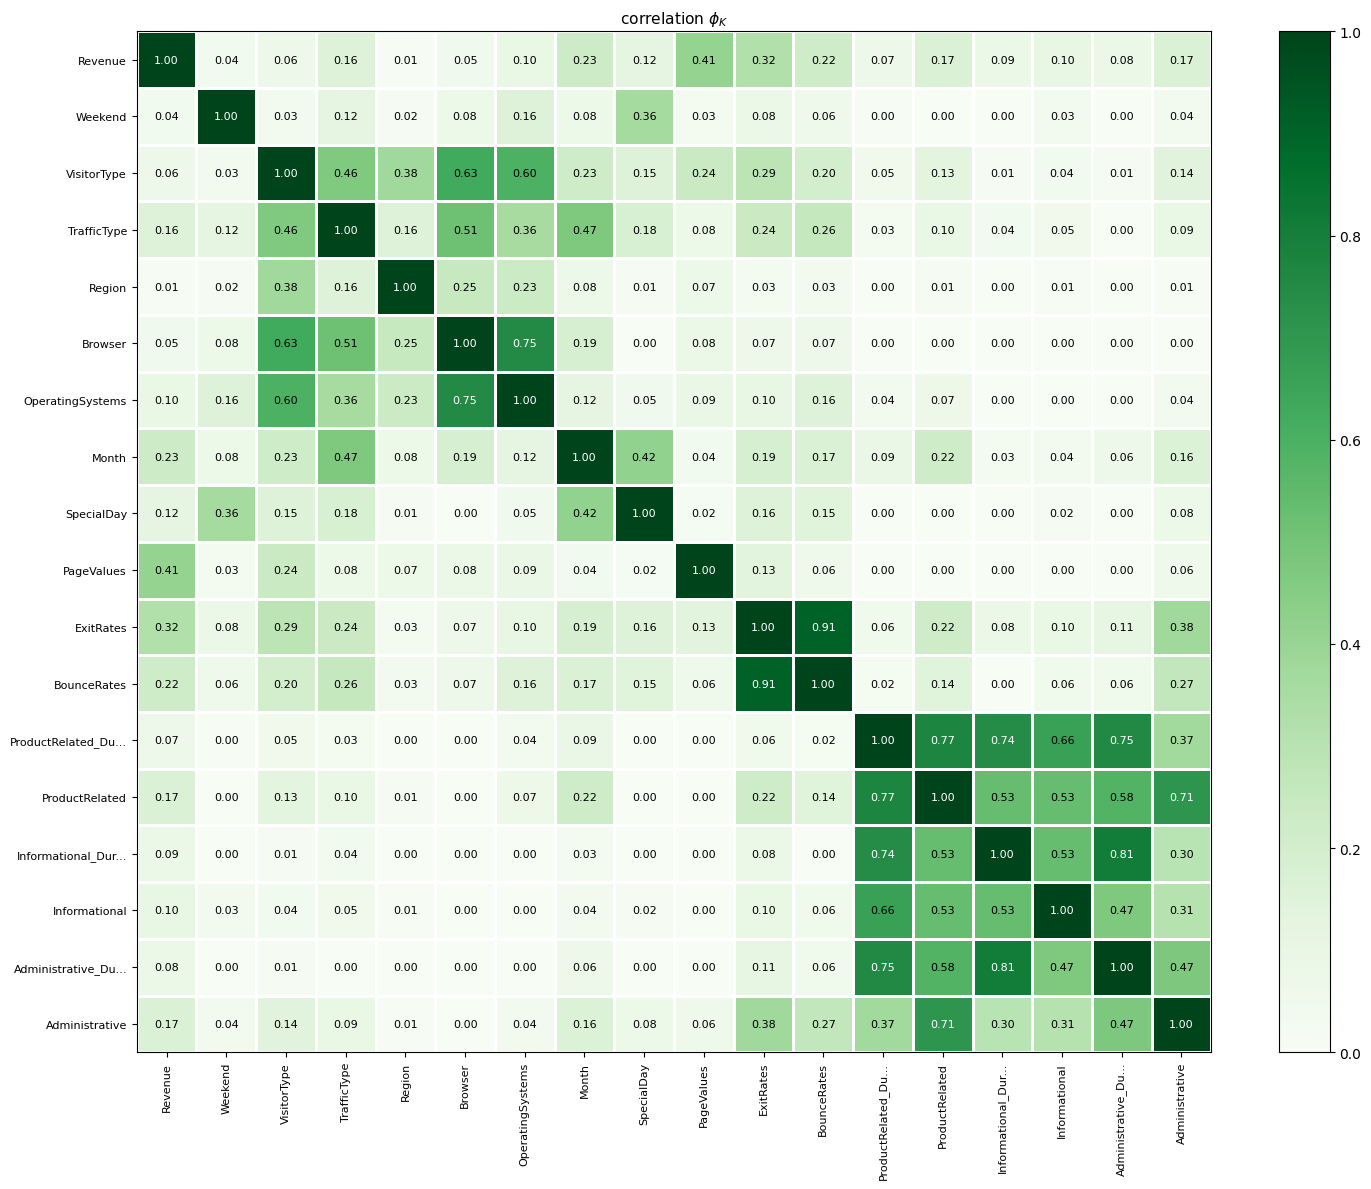

In [20]:
# построим тепловую карту
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8,
                        figsize=(15, 12))
plt.tight_layout()

- Видим высокую корреляцию между признаками `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated` и `ProductRelated_Duration`. Трогать их не будем, у меня нет точной информации что подразумевается под этими столбцами и есть ли доступ к Administrative страницам у обычных пользователей. Моделям это не помешает, потому что у нас линейных моделей не будет, которые не справляются с мультиколлинеарностью
- Также выскокая коллинеарность между парами `OperatingSystems` - `VisitorType`,`Browser` - `VisitorType`
- `Browser`, `Weekend` и `Region` не коррилируют с целевым признаком - удалим эти столбцы
- Также у нас данные только за один неполный год, и мы не можем проследить как поведение пользователя зависит от сезонности. Поэтому удалим стобец `Month`

In [21]:
# удалим вышеупомянутые столбцы
df = df.drop('Browser', axis=1)
df = df.drop('Weekend', axis=1)
df = df.drop('Region', axis=1)
df = df.drop('Month', axis=1)

In [22]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,TrafficType,VisitorType,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,Returning_Visitor,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,Returning_Visitor,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,3,Returning_Visitor,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,4,Returning_Visitor,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,4,Returning_Visitor,False


In [23]:
# поменяем тип данных Revenue на int (1 и 0) вместо типа bool
df['Revenue'] = df['Revenue'].astype('int')

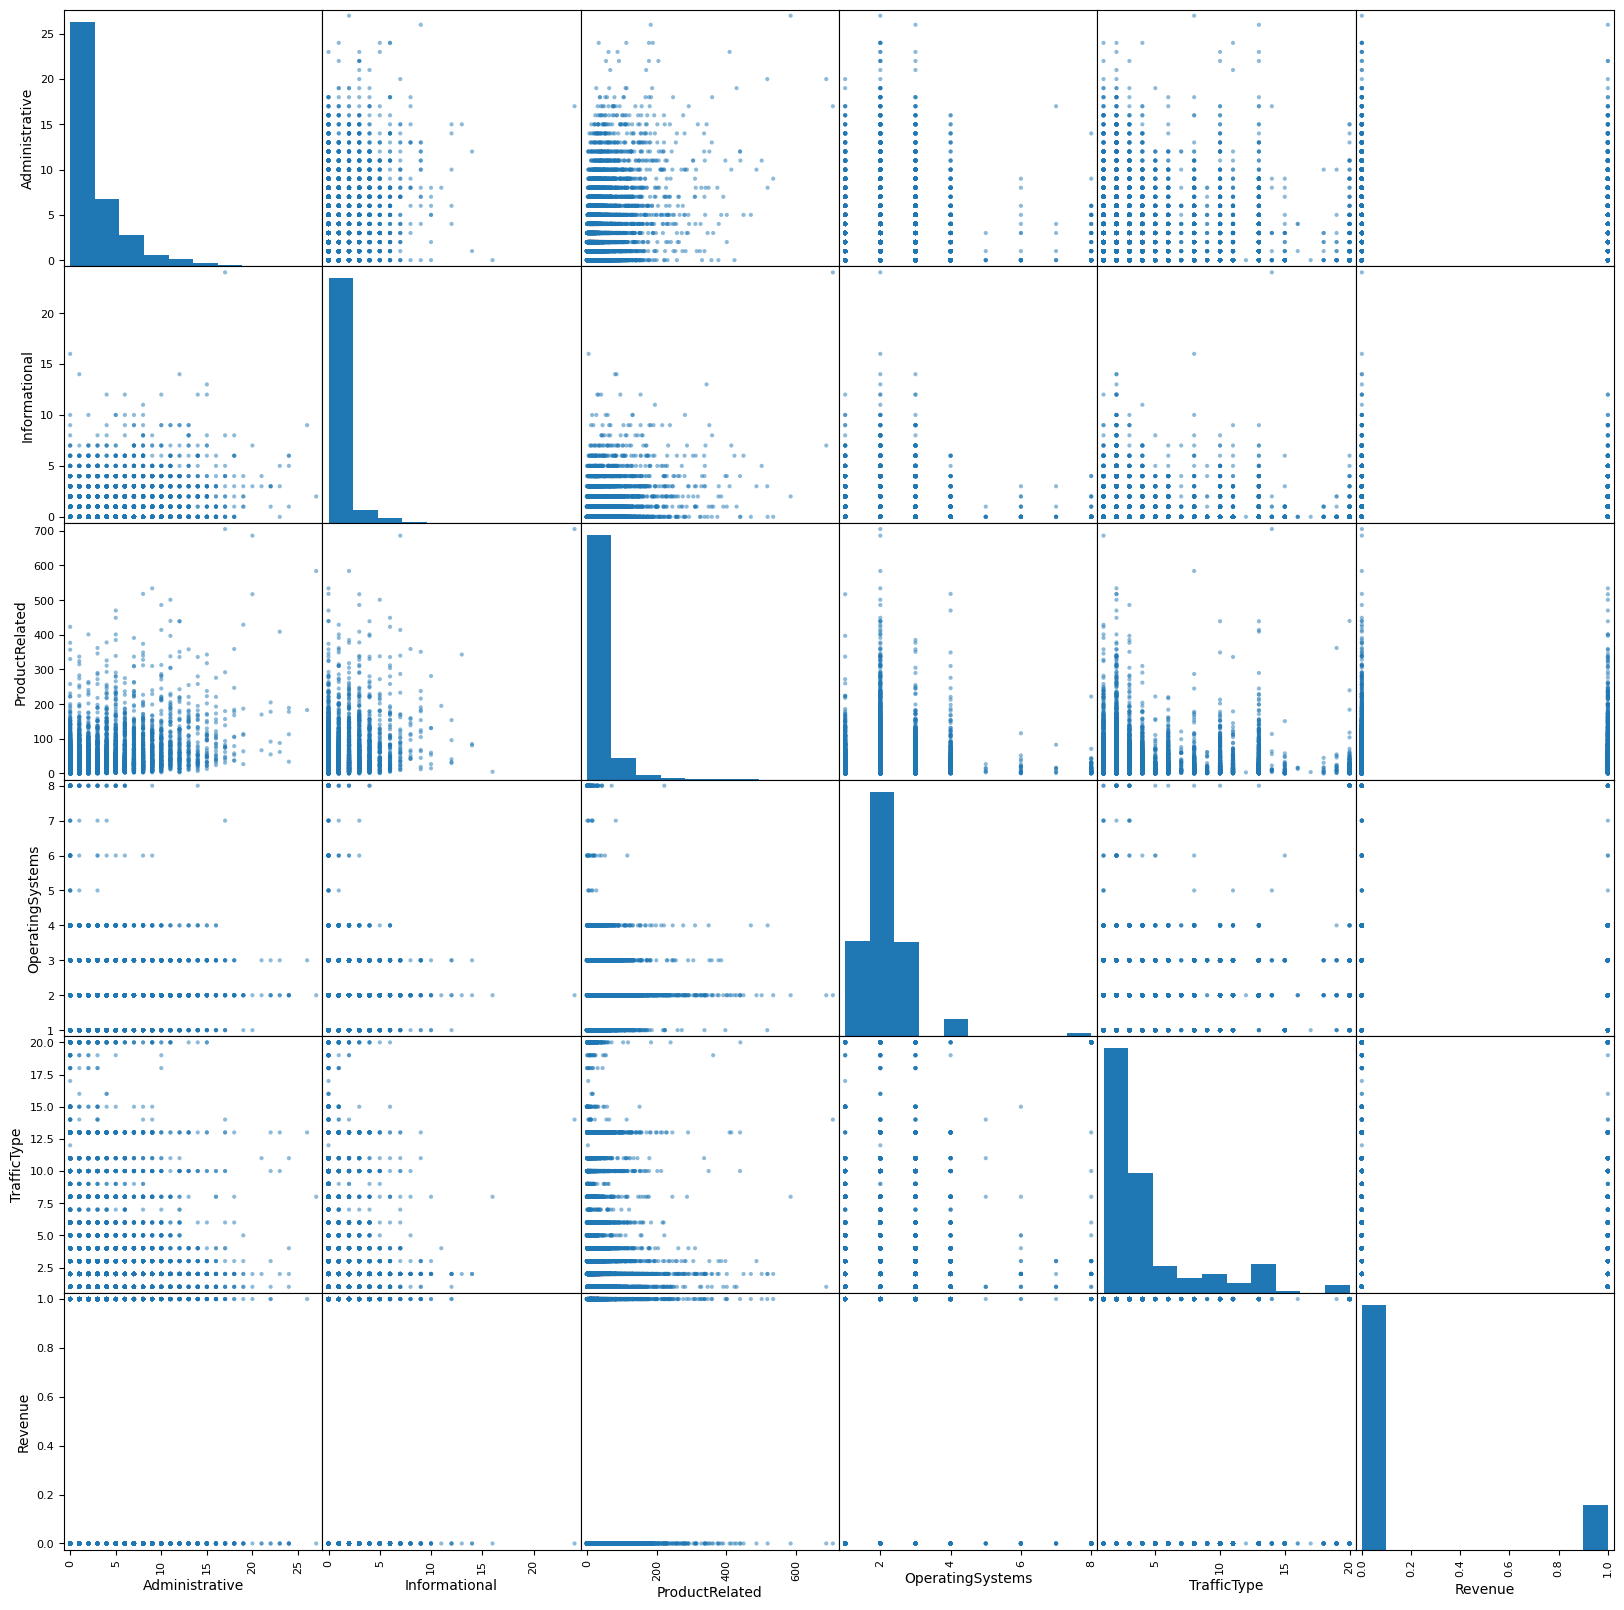

In [24]:
pd.plotting.scatter_matrix(df[df.select_dtypes(include=['int']).columns.to_list()], figsize=(20, 20));

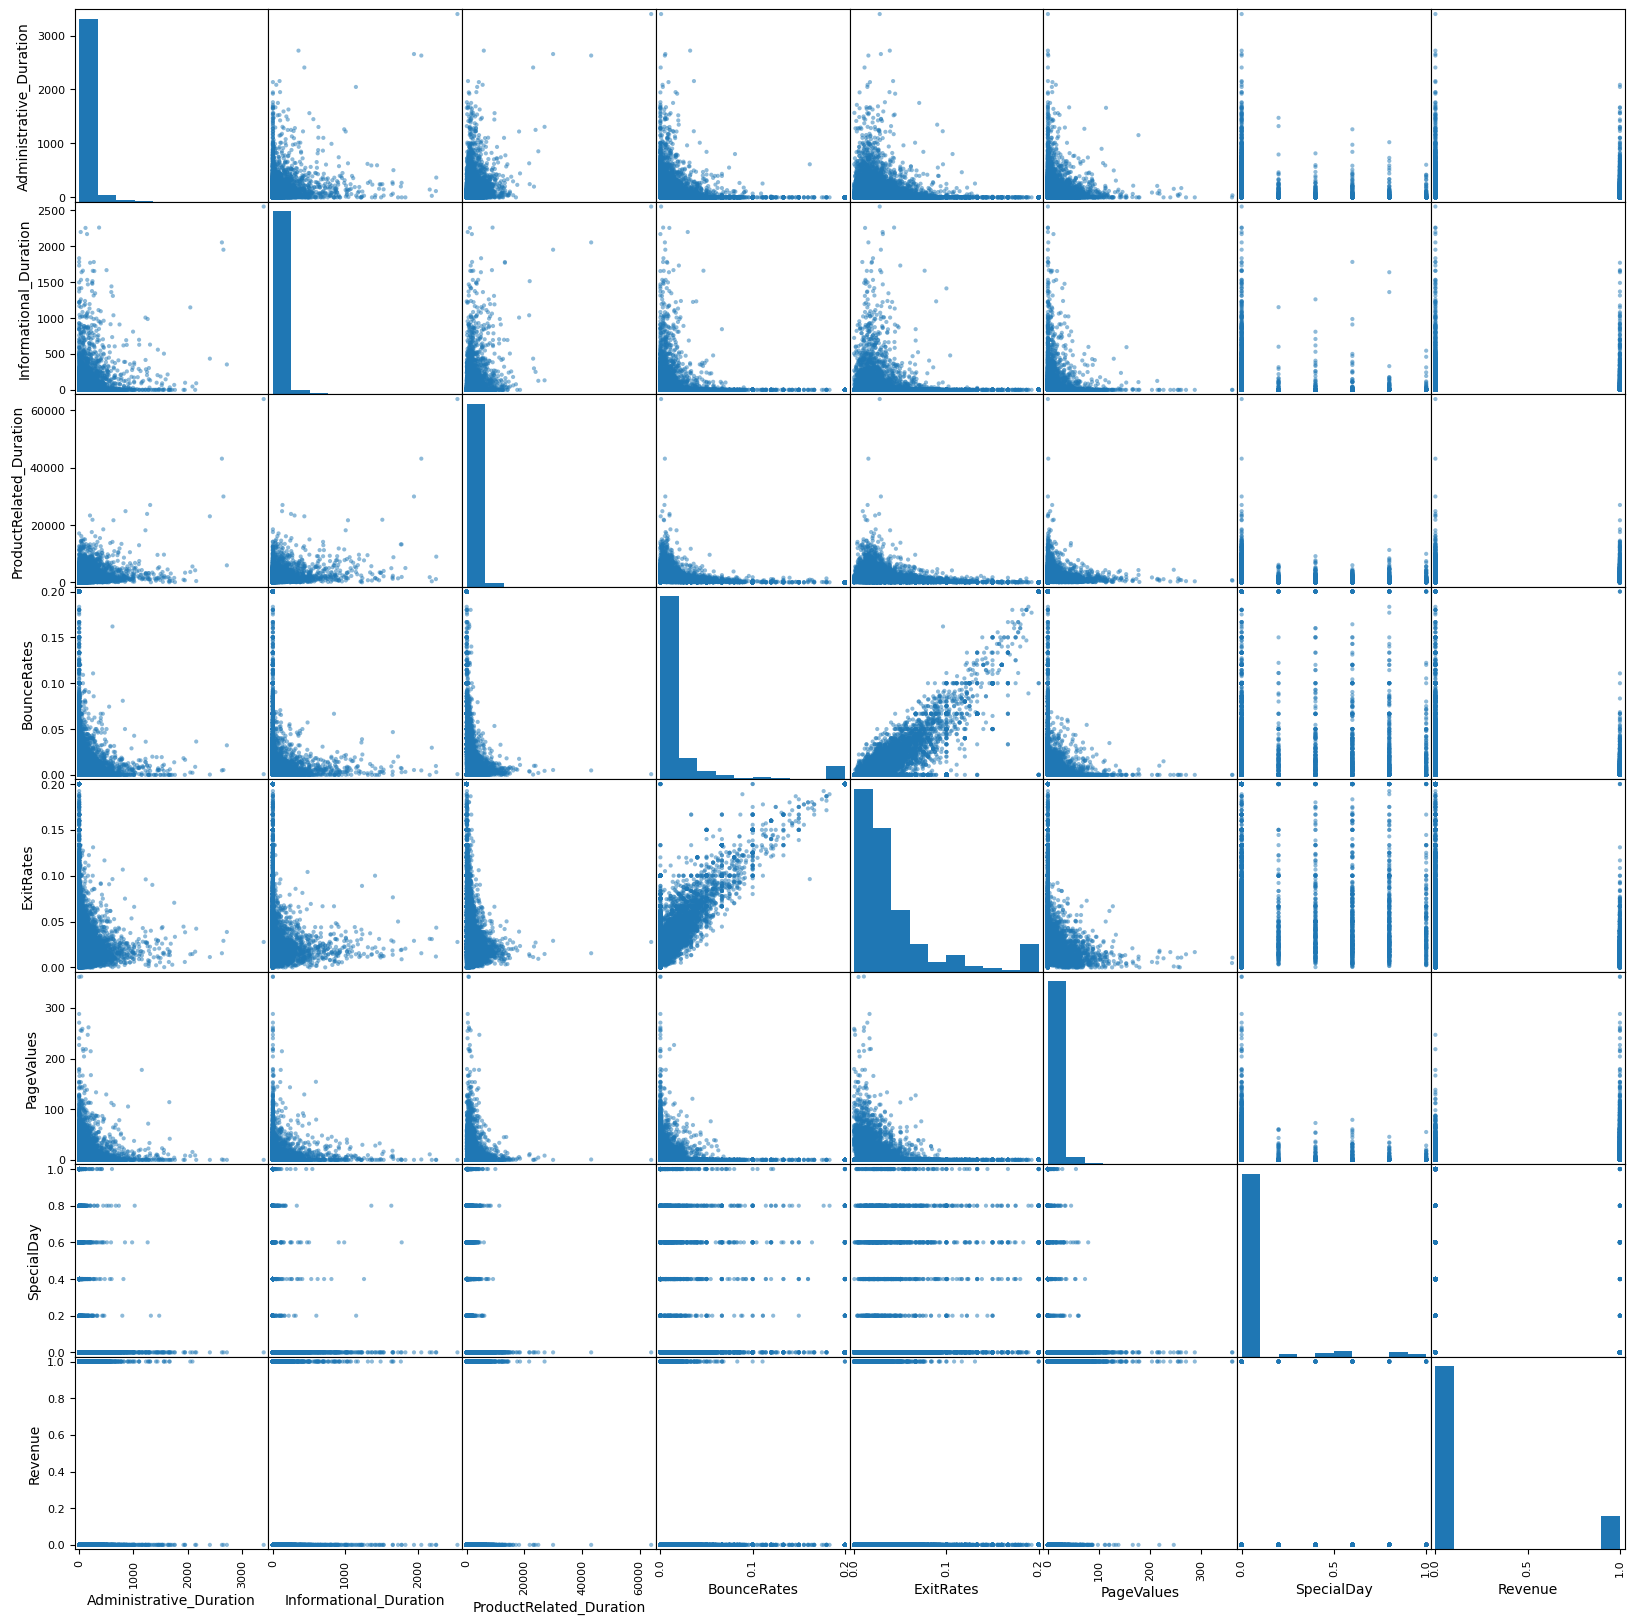

In [25]:
s = df.select_dtypes(include=['float']).columns.to_list()
s.append('Revenue')
pd.plotting.scatter_matrix(df[s], figsize=(20, 20));

In [26]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,TrafficType,VisitorType,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,Returning_Visitor,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,Returning_Visitor,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,3,Returning_Visitor,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,4,Returning_Visitor,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,4,Returning_Visitor,0


**Вывод исследовательского анализа:**
Из проведенного анализа следует следующее:

1. Распределение числовых признаков является Пуассоновским, но существуют различия между ними.

2. Признаки, связанные с количеством посещений страниц, продолжительностью сеанса и PageValues, проявляют большую вариабельность (дисперсию) для объектов класса 1. В то же время, для объектов класса 0 характерно сосредоточение плотности распределения в области низких значений. Для класса 1 наблюдается распространение плотности распределения и на значения, отличные от нуля.

3. Признаки `BounceRates` и `ExitRates` проявляют большую дисперсию для объектов класса 0. Это свидетельствует о том, что высокие значения этих признаков соответствуют высокой вероятности отказа и выхода клиентов без совершения покупки.

4. Обнаружена высокая корреляция между признаками `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated` и `ProductRelated_Duration`. Наличие мультиколлинеарности не будет проблемой для моделирования, так как используемые модели не требуют линейной независимости признаков.

5. Наблюдается высокая коллинеарность между парами признаков `OperatingSystems` - `VisitorType` и `Browser` - `VisitorType`.

6. Признаки `Browser`, `Weekend` и `Region` не коррелируют с целевым признаком и они были удалены из датасета

7. Из-зп того, что у нас данные только за один неполный год, и мы не можем проследить как поведение пользователя зависит от сезонности. Поэтому удалили стобец `Month`, чтобы избежать утечки

7. Матрица рассеяния подтверждает выявленные зависимости между признаками и целевым признаком.

### 3. Обучение моделей и предобработка (если нужно)

**ВАЖНО:**
Признак `Month` был удалён, чтобы избежать утечки. Если на этом признаке рбучать модели, метрика выше (пробовал)

**Выбор метрики, по которой будем оценивать модели:**
В нашей задаче нам важна не метка сама по себе, а правильный порядок на объектах. То есть компании скорее интересно упорядочить клиентов по вероятности конверсии и в зависимости от этого оценивать, какие действия могут привести к конверсии. Поэтому имеет смысл применять метрику AUC

In [27]:
# сделаем так, чтобы отображались все столбцы
pd.set_option('display.max_columns', None)

In [28]:
df['TrafficType'].value_counts()

2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: TrafficType, dtype: int64

In [29]:
# изменим тип данных на object у OperatingSystems и TrafficType
df['OperatingSystems'] = df['OperatingSystems'].astype('object')
df['TrafficType'] = df['TrafficType'].astype('object')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12330 non-null  object 
 11  TrafficType              12330 non-null  object 
 12  VisitorType              12330 non-null  object 
 13  Revenue                  12330 non-null  int64  
dtypes: float64(7), int64(4

In [31]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,TrafficType,VisitorType,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,Returning_Visitor,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,Returning_Visitor,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,3,Returning_Visitor,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,4,Returning_Visitor,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,4,Returning_Visitor,0


In [32]:
# разделим датасет на тренировочную и тестовые выборки
features = df.drop(['Revenue'], axis=1)
target = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9247 entries, 6157 to 8632
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           9247 non-null   int64  
 1   Administrative_Duration  9247 non-null   float64
 2   Informational            9247 non-null   int64  
 3   Informational_Duration   9247 non-null   float64
 4   ProductRelated           9247 non-null   int64  
 5   ProductRelated_Duration  9247 non-null   float64
 6   BounceRates              9247 non-null   float64
 7   ExitRates                9247 non-null   float64
 8   PageValues               9247 non-null   float64
 9   SpecialDay               9247 non-null   float64
 10  OperatingSystems         9247 non-null   object 
 11  TrafficType              9247 non-null   object 
 12  VisitorType              9247 non-null   object 
dtypes: float64(7), int64(3), object(3)
memory usage: 1011.4+ KB


In [34]:
y_train.shape

(9247,)

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3083 entries, 11355 to 3869
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           3083 non-null   int64  
 1   Administrative_Duration  3083 non-null   float64
 2   Informational            3083 non-null   int64  
 3   Informational_Duration   3083 non-null   float64
 4   ProductRelated           3083 non-null   int64  
 5   ProductRelated_Duration  3083 non-null   float64
 6   BounceRates              3083 non-null   float64
 7   ExitRates                3083 non-null   float64
 8   PageValues               3083 non-null   float64
 9   SpecialDay               3083 non-null   float64
 10  OperatingSystems         3083 non-null   object 
 11  TrafficType              3083 non-null   object 
 12  VisitorType              3083 non-null   object 
dtypes: float64(7), int64(3), object(3)
memory usage: 337.2+ KB


In [36]:
y_test.shape

(3083,)

Всё хорошо, данные без пропусков. Проппорции тренировочной и тестовой соблюдены

In [37]:
# создадим датафрейм для фиксации работы моделей
res = pd.DataFrame(columns=['hyperparameter_tuning', 'roc_auc'],
                   index = ['CatBoost', 'RandomForest', 'LightGBM'])

In [38]:
res

,hyperparameter_tuning,roc_auc
CatBoost,NaN,NaN
RandomForest,NaN,NaN
LightGBM,NaN,NaN


**CatBoost**

In [39]:
%%time
cat_features = ['VisitorType', 'OperatingSystems', 'TrafficType']
start = time.time()
# Задаем гиперпараметры для случайного поиска
param_dist = {
    'iterations': sp_randint(100, 1000),
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'depth': sp_randint(3, 10),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'random_strength': [0.1, 0.5, 1],
    'bagging_temperature': [0.5, 1, 1.5],
    'border_count': [32, 64, 128],
}

# Создаем экземпляр модели CatBoostClassifier
catboost_model = CatBoostClassifier(random_state=RANDOM_STATE)

# Создаем объект RandomizedSearchCV
catboost = RandomizedSearchCV(catboost_model, param_distributions=param_dist, scoring='roc_auc',
                                   n_iter=10, cv=5, verbose=1, random_state=RANDOM_STATE)

# Обучение модели с подбором гиперпараметров
catboost.fit(X_train, y_train, cat_features=cat_features)
end = time.time()
hyperparametr_tuning_time_catboost = end - start




Выходные данные были обрезаны до нескольких последних строк (5000).
266:	learn: 0.1367512	total: 2.28s	remaining: 4.95s
267:	learn: 0.1365721	total: 2.3s	remaining: 4.95s
268:	learn: 0.1364148	total: 2.3s	remaining: 4.94s
269:	learn: 0.1361402	total: 2.31s	remaining: 4.93s
270:	learn: 0.1360357	total: 2.32s	remaining: 4.92s
271:	learn: 0.1359496	total: 2.33s	remaining: 4.91s
272:	learn: 0.1355545	total: 2.33s	remaining: 4.9s
273:	learn: 0.1352395	total: 2.34s	remaining: 4.89s
274:	learn: 0.1351612	total: 2.35s	remaining: 4.88s
275:	learn: 0.1350194	total: 2.36s	remaining: 4.88s
276:	learn: 0.1347231	total: 2.37s	remaining: 4.87s
277:	learn: 0.1344875	total: 2.38s	remaining: 4.86s
278:	learn: 0.1341487	total: 2.39s	remaining: 4.85s
279:	learn: 0.1338359	total: 2.4s	remaining: 4.84s
280:	learn: 0.1336696	total: 2.4s	remaining: 4.83s
281:	learn: 0.1335869	total: 2.41s	remaining: 4.82s
282:	learn: 0.1332903	total: 2.42s	remaining: 4.81s
283:	learn: 0.1330708	total: 2.43s	remaining: 4.8s
28

In [40]:
# Выводим наилучшие гиперпараметры и значение метрики на валидационной выборке
print("Best Parameters: ", catboost.best_params_)
print("Best Score: ", catboost.best_score_)

Best Parameters:  {'bagging_temperature': 0.5, 'border_count': 128, 'depth': 5, 'iterations': 327, 'l2_leaf_reg': 9, 'learning_rate': 0.01, 'random_strength': 0.5}
Best Score:  0.9136564267721091


In [41]:
res.loc['CatBoost', 'roc_auc'] = catboost.best_score_
res.loc['CatBoost', 'hyperparameter_tuning'] = hyperparametr_tuning_time_catboost

In [42]:
res

,hyperparameter_tuning,roc_auc
CatBoost,285.64607,0.913656
RandomForest,NaN,NaN
LightGBM,NaN,NaN


**RandomForest**

Перед обучением RandomForest нужно:
- Разобраться с категориальными признаками (RandomForest не умеет с ними работать)
- Разобраться с разной дисперсией значений у разных признаков (RandomForest может давать больший вес признакам с большей дисперсией)

Теперь нужно разобраться с типами данных

In [43]:
# катеогориальные признаки для ohe
ohe_features = X_train.select_dtypes(include='object').columns.to_list()
ohe_features

['OperatingSystems', 'TrafficType', 'VisitorType']

In [44]:
# создадим датафрейм X_train_ohe, к которому будем применять OHE
X_train_ohe = X_train.copy()

In [45]:
# проведём кодирование категориальных признаков
encoder_ohe = OneHotEncoder(drop='first', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(X_train_ohe[ohe_features])

# добавляем закодированные признаки в X_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
X_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_ohe[ohe_features])

# удаляем изначально незакодированные категориальные признаки
X_train_ohe = X_train_ohe.drop(ohe_features, axis=1)

In [46]:
X_train_ohe.head(10)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor
6157,5,44.016667,0,0.0,4,162.533333,0.000000,0.000000,39.276740,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8147,0,0.000000,0,0.0,9,246.500000,0.125926,0.138889,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10316,0,0.000000,0,0.0,2,180.147059,0.033333,0.055556,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1603,0,0.000000,0,0.0,2,22.000000,0.000000,0.100000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6944,5,39.700000,0,0.0,14,253.600000,0.000000,0.018333,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3884,8,820.800000,1,29.5,59,1609.313889,0.010448,0.030795,12.440307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1297,0,0.000000,0,0.0,3,90.000000,0.000000,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
605,0,0.000000,0,0.0,4,505.000000,0.000000,0.050000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2308,0,0.000000,0,0.0,15,432.500000,0.000000,0.015385,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10151,1,7.000000,0,0.0,5,78.500000,0.000000,0.028571,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
# создадим датафрейм X_test_ohe, к которому будем применять OHE  и применим обученную на X_train_ohe OHE
X_test_ohe = X_test.copy()
X_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_ohe[ohe_features])

In [48]:
X_test_ohe = X_test_ohe.drop(ohe_features, axis=1)

In [49]:
X_test_ohe.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor
11355,0,0.000000,0,0.000000,9,1178.250000,0.000000,0.025000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7971,17,626.493333,0,0.000000,76,1985.894203,0.015630,0.031102,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8930,0,0.000000,0,0.000000,7,305.500000,0.000000,0.028571,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9371,14,160.111539,6,1079.833333,154,7405.360281,0.004924,0.021453,8.533928,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11261,0,0.000000,0,0.000000,8,866.000000,0.050000,0.058333,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Всё хорошо, применили кодировку OHE. Теперь нужно масштабировать признаки

In [50]:
# напишем функцию для масштабирования признаков
def scaler(data, num_features):
    scaler = StandardScaler()
    scaler.fit(X_train[num_features])
    data[num_features] = scaler.transform(data[num_features])
    return data

In [51]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,TrafficType,VisitorType,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,Returning_Visitor,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,Returning_Visitor,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,3,Returning_Visitor,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,4,Returning_Visitor,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,4,Returning_Visitor,0


In [52]:
# числовые признаки
num_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
               'ProductRelated', 'ProductRelated_Duration', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
               'PageValues']

In [53]:
# создадим доп. копии датафреймов, к которым будем применять StandardScaler
X_train_ohe_scaled = X_train_ohe.copy()
X_test_ohe_scaled = X_test_ohe.copy()

In [54]:
# масштабируем тренировочную выборку
scaler = StandardScaler()
scaler.fit(X_train_ohe[num_features])
X_train_ohe_scaled[num_features] = scaler.transform(X_train_ohe_scaled[num_features])

In [55]:
# масштабируем тестовую выборку
X_test_ohe_scaled[num_features] = scaler.transform(X_test_ohe_scaled[num_features])

In [56]:
X_train_ohe_scaled.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor
6157,0.823297,-0.200262,-0.390604,-0.244319,-0.624399,-0.527635,-0.458593,-0.891225,1.845356,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8147,-0.690950,-0.448998,-0.390604,-0.244319,-0.510437,-0.484250,2.147963,1.976641,-0.314820,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10316,-0.690950,-0.448998,-0.390604,-0.244319,-0.669984,-0.518534,0.231378,0.255921,-0.314820,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1603,-0.690950,-0.448998,-0.390604,-0.244319,-0.669984,-0.600247,-0.458593,1.173638,-0.314820,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6944,0.823297,-0.224655,-0.390604,-0.244319,-0.396475,-0.480582,-0.458593,-0.512666,-0.314820,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [57]:
X_test_ohe_scaled.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems_2,OperatingSystems_3,OperatingSystems_4,OperatingSystems_5,OperatingSystems_6,OperatingSystems_7,OperatingSystems_8,TrafficType_2,TrafficType_3,TrafficType_4,TrafficType_5,TrafficType_6,TrafficType_7,TrafficType_8,TrafficType_9,TrafficType_10,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_Other,VisitorType_Returning_Visitor
11355,-0.690950,-0.448998,-0.390604,-0.244319,-0.510437,-0.002828,-0.458593,-0.375009,-0.314820,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7971,4.457488,3.091278,-0.390604,-0.244319,1.016654,0.414471,-0.135060,-0.249010,-0.314820,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8930,-0.690950,-0.448998,-0.390604,-0.244319,-0.556022,-0.453766,-0.458593,-0.301264,-0.314820,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9371,3.548940,0.455783,4.333945,7.433392,2.794462,3.214638,-0.356665,-0.448250,0.154536,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11261,-0.690950,-0.448998,-0.390604,-0.244319,-0.533229,-0.164163,0.576363,0.313279,-0.314820,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Применили StandardScaler. Теперь нужно приступать к обучению

In [58]:
# Подберём гиперпараметры для RandomForestRegressor
parameter_tuning_start = time.time()
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_grid = {
    'max_depth': range(2, 10),
    'n_estimators': range(1, 1000),
    'min_samples_leaf': (2, 3, 4),
    'min_samples_split': (1, 2, 3, 4),
}
rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=10)

rf.fit(X_train_ohe_scaled, y_train);
parameter_tuning_end = time.time()
# подсчёт времени подбора гиперпараметров
parameter_tuning_time_rf = parameter_tuning_end - parameter_tuning_start

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908
[CV 1/5; 1/10] END max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908;, score=nan total time=   0.0s
[CV 2/5; 1/10] START max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908
[CV 2/5; 1/10] END max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908;, score=nan total time=   0.0s
[CV 3/5; 1/10] START max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908
[CV 3/5; 1/10] END max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908;, score=nan total time=   0.0s
[CV 4/5; 1/10] START max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908
[CV 4/5; 1/10] END max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators=908;, score=nan total time=   0.0s
[CV 5/5; 1/10] START max_depth=7, min_samples_leaf=3, min_samples_split=1, n_estimators

In [59]:
print('Подобранные гиперпараметры для модели:', rf.best_params_)
print('Средняя оценка качества модели:', (rf.best_score_))

Подобранные гиперпараметры для модели: {'n_estimators': 979, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 9}
Средняя оценка качества модели: 0.9121713632050262


In [60]:
res.loc['RandomForest', 'roc_auc'] = rf.best_score_
res.loc['RandomForest', 'hyperparameter_tuning'] = parameter_tuning_time_rf

In [61]:
res

,hyperparameter_tuning,roc_auc
CatBoost,285.64607,0.913656
RandomForest,75.096468,0.912171
LightGBM,NaN,NaN


**LightGBM**

LightGBM обучаю в GoogleColab, потому что компьютер не поодерживают библиотеку. Поэтому скачиваем тренировочную и тестовую выборку. И скопирую сюда все ячейки оттуда.

Нам нужно будет задать категориальные признаки

In [64]:
# создадим список категориальных признаков
cat_features = ['VisitorType', 'OperatingSystems', 'TrafficType']

In [65]:
# поменяем тип данных на category, чтобы передать модели
X_train[cat_features] = X_train[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9247 entries, 6157 to 8632
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           9247 non-null   int64   
 1   Administrative_Duration  9247 non-null   float64 
 2   Informational            9247 non-null   int64   
 3   Informational_Duration   9247 non-null   float64 
 4   ProductRelated           9247 non-null   int64   
 5   ProductRelated_Duration  9247 non-null   float64 
 6   BounceRates              9247 non-null   float64 
 7   ExitRates                9247 non-null   float64 
 8   PageValues               9247 non-null   float64 
 9   SpecialDay               9247 non-null   float64 
 10  OperatingSystems         9247 non-null   category
 11  TrafficType              9247 non-null   category
 12  VisitorType              9247 non-null   category
dtypes: category(3), float64(7), int64(3)
memory usage: 822.9 KB


In [67]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3083 entries, 11355 to 3869
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           3083 non-null   int64   
 1   Administrative_Duration  3083 non-null   float64 
 2   Informational            3083 non-null   int64   
 3   Informational_Duration   3083 non-null   float64 
 4   ProductRelated           3083 non-null   int64   
 5   ProductRelated_Duration  3083 non-null   float64 
 6   BounceRates              3083 non-null   float64 
 7   ExitRates                3083 non-null   float64 
 8   PageValues               3083 non-null   float64 
 9   SpecialDay               3083 non-null   float64 
 10  OperatingSystems         3083 non-null   category
 11  TrafficType              3083 non-null   category
 12  VisitorType              3083 non-null   category
dtypes: category(3), float64(7), int64(3)
memory usage: 275.1 KB

С данными всё хорошо, можно обучать модель

In [69]:
%%time
start = time.time()
# Задаем гиперпараметры для случайного поиска
param_dist = {
    'n_estimators': sp_randint(100, 1000),
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': sp_randint(3, 10),
    'num_leaves': sp_randint(10, 100),
    'min_child_samples': sp_randint(5, 50),
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


# Создаем экземпляр модели LightGBM Classifier
model_lgb = lgb.LGBMClassifier(random_state = RANDOM_STATE)

# Создаем объект RandomizedSearchCV
lgb_classifier = RandomizedSearchCV(model_lgb, param_distributions=param_dist, n_iter=10,
                                    cv=5, scoring='roc_auc', random_state = RANDOM_STATE, verbose=10)

# Обучение модели с подбором гиперпараметров
lgb_classifier.fit(X_train, y_train)
end = time.time()
hyperparametr_tuning_lgb = end - start


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_samples=23, n_estimators=826, num_leaves=74, reg_alpha=0.1, reg_lambda=0, subsample=0.7
[CV 1/5; 1/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_samples=23, n_estimators=826, num_leaves=74, reg_alpha=0.1, reg_lambda=0, subsample=0.7;, score=0.909 total time=   0.4s
[CV 2/5; 1/10] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_samples=23, n_estimators=826, num_leaves=74, reg_alpha=0.1, reg_lambda=0, subsample=0.7
[CV 2/5; 1/10] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_samples=23, n_estimators=826, num_leaves=74, reg_alpha=0.1, reg_lambda=0, subsample=0.7;, score=0.895 total time=   0.4s
[CV 3/5; 1/10] START colsample_bytree=0.7, learning_rate=0.1, max_depth=3, min_child_samples=23, n_estimators=826, num_leaves=74, reg_alpha=0.1, reg_lambda=0, subsample=0.7
[CV 3/5; 1/1

In [70]:
# Выводим наилучшие гиперпараметры и значение метрики на валидационной выборке
print("Best Parameters: ", lgb_classifier.best_params_)
print("Best Score: ", lgb_classifier.best_score_)
#print('Hyperparametr tuning time:', hyperparametr_tuning_lgb)

Best Parameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_samples': 35, 'n_estimators': 610, 'num_leaves': 69, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.9}
Best Score:  0.9171005255481915


In [71]:
# Получаем лучшую обученную модель
best_model = lgb_classifier.best_estimator_

In [72]:
res.loc['LightGBM', 'hyperparameter_tuning'] = hyperparametr_tuning_lgb
res.loc['LightGBM', 'roc_auc'] = lgb_classifier.best_score_

In [73]:
res

,hyperparameter_tuning,roc_auc
CatBoost,285.64607,0.913656
RandomForest,75.096468,0.912171
LightGBM,33.806043,0.917101


**Вывод:**
- Был удалён столбец `Month`, чтобы избежать утечки
- Была проведена предобработка данных под каждую модель
    - Для `CatBoost` данные не были предобработаны как-то специфически
    - Для `RandomForest` был применём ка данным `OHE` и `StandardScaler`
    - Для `LightGBM` были изменены типы категориальных данных на category
- `CatBoost` показал `ROC-AUC = 0.914`, с временем подбора гиперпараметров и обучения `286 секунд`
- `RandomForest` показал `ROC-AUC = 0.912`, с временем подбора гиперпараметров и обучения `75 секунд`
- `LightGBM` показал `ROC-AUC = 0.917`, с временем подбора гиперпараметров и обучения `34 секунд`
- Выбираем как итоговую модель `LightGBM`

### 6. Проверка финальной модели на тестовой выборке

In [74]:
X_test.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,TrafficType,VisitorType
11355,0,0.000000,0,0.000000,9,1178.250000,0.000000,0.025000,0.000000,0.0,3,10,Returning_Visitor
7971,17,626.493333,0,0.000000,76,1985.894203,0.015630,0.031102,0.000000,0.0,2,1,Returning_Visitor
8930,0,0.000000,0,0.000000,7,305.500000,0.000000,0.028571,0.000000,0.0,2,3,Returning_Visitor
9371,14,160.111539,6,1079.833333,154,7405.360281,0.004924,0.021453,8.533928,0.0,4,1,Returning_Visitor
11261,0,0.000000,0,0.000000,8,866.000000,0.050000,0.058333,0.000000,0.0,2,6,Returning_Visitor


In [75]:
# Получение прогнозов модели на тестовой выборке
predictions_test_lgb = best_model.predict_proba(X_test)

# Вычисление ROC-AUC
roc_auc_lgb = roc_auc_score(y_test, predictions_test_lgb[:, 1])

# Вывод значения метрики ROC-AUC
print("ROC-AUC Score на тестовой выборке:", roc_auc_lgb)


ROC-AUC Score на тестовой выборке: 0.9169887689614935


In [76]:
# вычисление accuracy и f1
accuracy = accuracy_score(y_test, best_model.predict(X_test))
f1 = f1_score(y_test, best_model.predict(X_test))
print('Accuracy лучшей модели на тестовой выборке:', accuracy)
print('F1 лучшей модели на тестовой выборке:', f1)

Accuracy лучшей модели на тестовой выборке: 0.8936101200129744
F1 лучшей модели на тестовой выборке: 0.6322869955156951


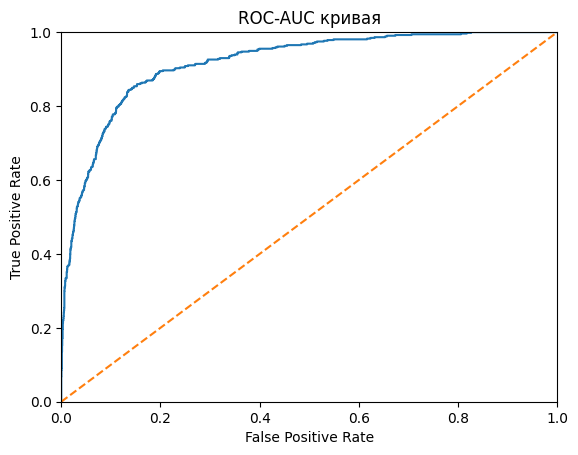

In [77]:
# вычислим покзатели точности и полноты для разных порогов tresholds
#probabilities_test = best_model_RF_upsampled.predict_proba(features_test)


probabilities_test = best_model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, tresholds = roc_curve(y_test, probabilities_one_test)


# построим ROC-кривую
plt.plot()
plt.plot(fpr, tpr, label='LGBM')

plt.plot([0, 1], [0, 1], linestyle='--') # кривая для случайной модели
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC кривая')
plt.show()

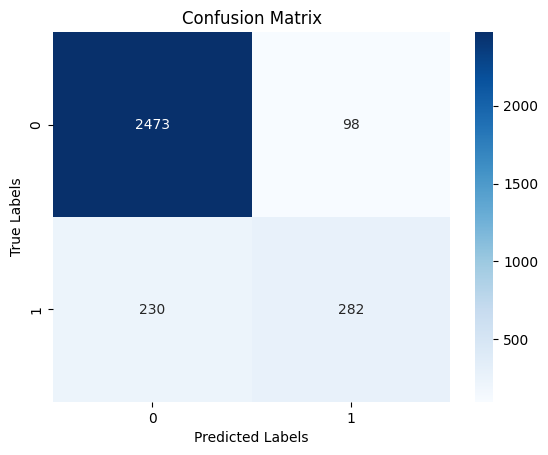

In [82]:
# Вычислим матрицу ошибок

probs = best_model.predict_proba(X_test)[:, 1]
threshold = 0.5
predictions = (probs >= threshold).astype(int)
confusion = confusion_matrix(y_test, predictions)


# Создадим тепловую карту матрицы ошибок с использованием seaborn
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")

# Добавим метки осей и заголовок
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Отобразим визуализацию
plt.show()

Из матрицы ошибок видим:

- True positive - 282
- True Negative - 2473
- False positive - 98
- False Negative - 230



На ROC-AUC кривой видно, что модель работает.

Синяя кривая - наша лучшая модель, пунктирная - случаяная модель


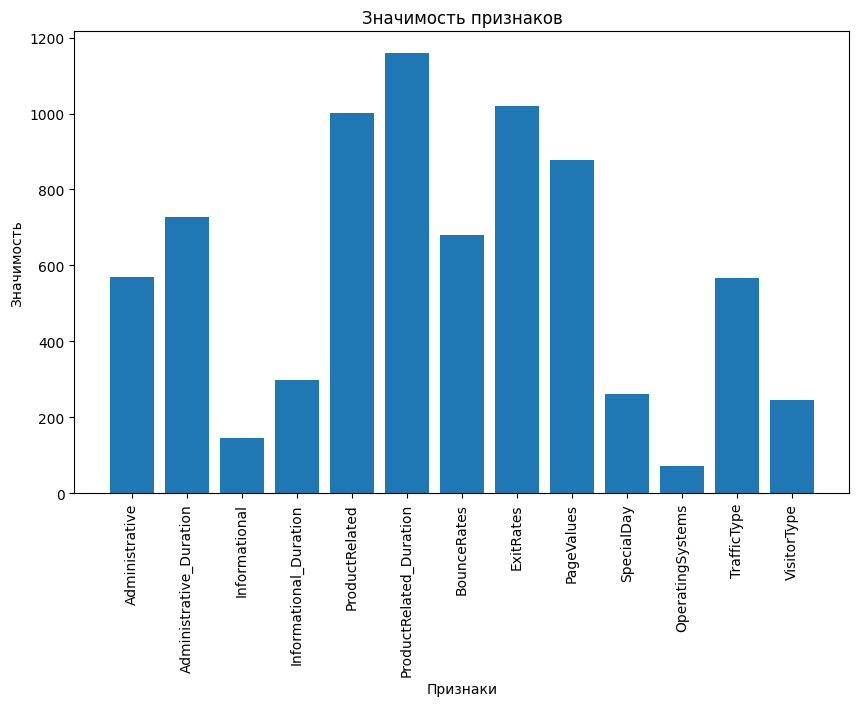

In [79]:
# Получение значимости признаков
feature_importances = best_model.feature_importances_

# Визуализация значимости признаков
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, feature_importances)
plt.xticks(rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Значимость')
plt.title('Значимость признаков')
plt.show()

**Итоговый вывод:**
В результате исследовательского анализа данных были получены следующие выводы:

- Итоговой моделью была выбрана `LightGBM`, которая показала `ROC-AUC` на тестовой выборке равный `0.917`. `Accuracy` модели на тестовой выборке составила `0.89`, а `F1-мера - 0.63`.
- Построив матрицу ошибок, опредеделили:
    - True positive - 282
    - True Negative - 2473
    - False positive - 98
    - False Negative - 230
- С помощью feature_importances_ получили рейтинг значимости признаков. Количество посещений сайтов, длительность сессий, показатель отказов стриницы, показатель выхода, ценность страницы (PageValues) и вид траффика влияют на итоговый Revenue

**С учетом вывода о значимости признаков, чтобы увеличить конверсию, рекомендуется сосредоточиться на следующих аспектах:**

1. Оптимизировать количество посещений сайтов: Повышение активности пользователей на сайте может быть достигнуто путем улучшения навигации, предлагая интересный и релевантный контент, улучшения пользовательского интерфейса и оптимизации процесса оформления покупки.

2. Улучшить длительность сессий: Создание привлекательного и захватывающего контента, удержание посетителей на сайте путем предлагания релевантных рекомендаций и продолжительных сессий, а также обеспечение понятной и удобной навигации может помочь продлить время, проведенное пользователями на сайте.

3. Снизить показатель отказов страницы и показатель выхода: Изучить аналитику посещений, чтобы выявить причины высокого показателя отказов и выхода с сайта. Оптимизировать дизайн и контент страниц, улучшить скорость загрузки, упростить процесс оформления покупки, предоставить достаточно информации и релевантных предложений, чтобы повысить удовлетворенность пользователей и снизить вероятность их ухода.

4. Уделить внимание ценности страницы (PageValues): Анализировать и оптимизировать страницы с высокой ценностью для пользователей, такие как страницы товаров, страницы с акциями и предложениями, страницы с информацией о доставке и гарантии, чтобы убедиться, что они достаточно привлекательны и убедительны для пользователей.

5. Рассмотреть виды трафика: Изучить источники трафика, определить наиболее эффективные каналы привлечения пользователей с высокой конверсией. Сосредоточиться на расширении и оптимизации этих каналов, например, путем улучшения рекламных кампаний или поисковой оптимизации.

В целом, для повышения конверсии рекомендуется фокусироваться на улучшении пользовательского опыта, предоставлении ценности и релевантности, оптимизации страниц и каналов привлечения, а также непрерывном анализе и оптимизации результатов для достижения желаемых целей.